In [17]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import lmdb
from pylab import *
from IPython.display import HTML
from random import shuffle
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # Smol images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '/opt/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe


In [3]:
caffe.set_mode_cpu()

model_def = caffe_root + 'examples/mnist/deploy.prototxt'
model_weights = caffe_root + 'examples/mnist/lenet_iter_10000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)


In [4]:
lmdb_env = lmdb.open(caffe_root + 'examples/mnist/mnist_test_lmdb')
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
datum = caffe.proto.caffe_pb2.Datum()

test_data = []
test_labels = []

for key, value in lmdb_cursor:
    datum.ParseFromString(value)
    label = datum.label
    data = caffe.io.datum_to_array(datum)
    test_data.append(data)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [5]:
test_class = zeros(len(test_labels))

for i, img in enumerate(test_data):
    net.blobs['data'].data[...] = img
    test_class[i] = net.forward()['loss'][0].argmax()

In [123]:
# Get start and end images
target_digit = 7
digit_idx = (test_labels == target_digit) & (test_class == target_digit)
digits = test_data[digit_idx]
start_img, end_img = [k[0] for k in digits[np.random.choice(digits.shape[0], 2, replace=False), :]]
biggerlist = [k[0] for k in digits[np.random.choice(digits.shape[0], 3, replace=False), :]]
biggerlist.append(biggerlist[0])

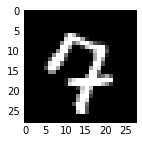

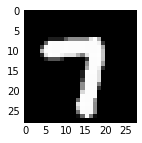

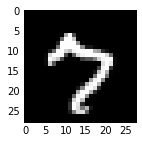

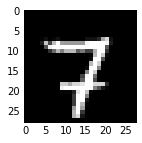

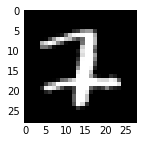

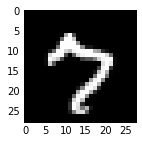

In [124]:
# Show start and end images
figure(figsize=(2, 2))
imshow(start_img, cmap='gray')
figure(figsize=(2, 2))
imshow(end_img, cmap='gray')
for k in biggerlist:
    figure(figsize=(2, 2))
    imshow(k, cmap='gray')

In [125]:
def transmogrify(start_img, end_img):
    img_sequence = [start_img]
    cur_img = start_img.copy()
    iteration = 0

    while any(cur_img != end_img):
        differences = zip(*np.where(cur_img != end_img))
        shuffle(differences)
        iteration += 1
        print("Iteration %d, found %d differences" % (iteration ,len(differences)))
        good_eggs = []
        for x, y in differences:
            test_img = cur_img.copy()
            delta = end_img[x][y] - test_img[x][y]
            delta = min(max(delta, -20), 20)
            test_img[x][y] += delta
            net.blobs['data'].data[...] = test_img
            classification = net.forward()['loss'].argmax()
            if classification == target_digit:
                good_eggs.append((net.blobs['loss'].data.max(), net.blobs['ip2'].data.max(), test_img))
        if not good_eggs:
            print("Couldn't move forwards")
            break
        cur_img = max(good_eggs, key=lambda x:x[:2])[2]
        img_sequence.append(cur_img)
    return img_sequence

img_sequence = transmogrify(start_img, end_img)

def transmogrifyseq(seq):
    sequences = []
    for i in xrange(1, len(seq)):
        sequences.append(transmogrify(seq[i-1], seq[i]))
    return [item for sublist in sequences for item in sublist]

#img_sequence = transmogrifyseq(biggerlist)


Iteration 1, found 193 differences
Iteration 2, found 192 differences


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in ubyte_scalars


Iteration 3, found 191 differences
Iteration 4, found 190 differences
Iteration 5, found 190 differences
Iteration 6, found 189 differences
Iteration 7, found 189 differences
Iteration 8, found 189 differences
Iteration 9, found 189 differences
Iteration 10, found 188 differences
Iteration 11, found 188 differences
Iteration 12, found 188 differences
Iteration 13, found 187 differences
Iteration 14, found 187 differences
Iteration 15, found 186 differences
Iteration 16, found 186 differences
Iteration 17, found 186 differences
Iteration 18, found 186 differences
Iteration 19, found 186 differences
Iteration 20, found 186 differences
Iteration 21, found 186 differences
Iteration 22, found 186 differences
Iteration 23, found 186 differences
Iteration 24, found 186 differences
Iteration 25, found 186 differences
Iteration 26, found 186 differences
Iteration 27, found 186 differences
Iteration 28, found 186 differences
Iteration 29, found 186 differences
Iteration 30, found 186 differences

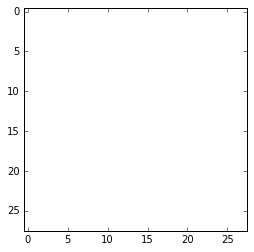

In [126]:
fig = plt.figure(figsize=(4,4))
ims = [(imshow(img, cmap='gray'),) for img in img_sequence]
im_ani = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=1000)

In [127]:
figure(figsize=(4, 4))
HTML(im_ani.to_html5_video())

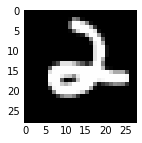

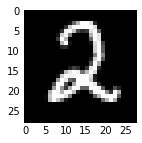

In [115]:
figure(figsize=(2, 2))
plt.imshow(img_sequence[0], cmap='gray')
figure(figsize=(2, 2))
plt.imshow(img_sequence[-1], cmap='gray')